In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.integrate import odeint

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [92]:
folder = 'TDE'
is_tde = True
snap = '196'
m = 5
beta = 2
path = f'{folder}/{snap}'
G = 1
Mbh = 10**m
Rt = Mbh**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2


Function for orbits

In [93]:
def to_cylindric(x,y):
    if x.any() == 0:
        if y.any()>0:
            theta_coord = np.pi/2
        elif y.any() == 0:
            theta_coord = 0
        else:
            theta_coord = 3/2 * np.pi
    else:
        theta_coord = np.arctan2(y,x)
    radius = np.sqrt(x**2+y**2)
    return radius, theta_coord

def from_cylindric(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def orbital_energy(r, v_xy, M = M_bh):
    # no angular momentum??
    energy = G*M/r - v_xy**2/2
    return energy

def normal_plane(x_data, y_data, dim_data, theta_chosen):
    r_plane = np.sqrt(x_data**2 + y_data**2)
    if np.abs(theta_chosen) == np.pi/2:
        condition_coord = np.abs(y_data) < dim_data # horizontal line
    else:
        m = np.tan(theta_chosen)
        condition_coord = np.logical_and(np.abs(y_data - m * x_data) < dim_data, r_plane > R0)
        if theta_chosen >= 0: # if theta is in the first or second quadrant
            condition_coord = np.logical_and(condition_coord, y_data > 0)
        else:
            condition_coord = np.logical_and(condition_coord, y_data < 0)
    return condition_coord


In [94]:
# cfr tidal disruption 
xRt = np.linspace(-Rt, Rt, 100)
yRt = np.linspace(-Rt, Rt, 100)
xcfr, ycfr = np.meshgrid(xRt,yRt)
cfr = xcfr**2 + ycfr**2 - Rt**2

# cfr smoothing lenght
xR0 = np.linspace(-R0, R0, 100)
yR0 = np.linspace(-R0, R0, 100)
xcfr0, ycfr0 = np.meshgrid(xR0,yR0)
cfr0 = xcfr0**2 + ycfr0**2 - R0**2


Load data

In [95]:
# sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp, IE, Diss, Entropy = make_tree(path, snap, is_tde, energy = True)
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde, energy = False)

Star = np.load(f'{path}/Star_{snap}.npy')
# div = np.load(f'{folder}/{snap}/DivV_{snap}.npy')
# shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
# shocksurface = np.loadtxt(f'data/{snap}/shocksurface_{snap}.txt')

R = np.sqrt(X**2 + Y**2 + Z**2)
Rcyl, theta = to_cylindric(X,Y)
V = np.sqrt(VX**2 + VY**2 + VZ**2)
Vcyl = np.sqrt(VX**2 + VY**2)
orb_en = orbital_energy(Rcyl, Vcyl)
dim_cell = Vol**(1/3) # according to Elad
time, tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m=m, choose = 'tfb')

# Shock zone
# idx_zone = shockzone[0]
# idx_zone = np.array([int(i) for i in idx_zone])
# x_zone = X[idx_zone]
# y_zone = Y[idx_zone]
# z_zone = Z[idx_zone]
# Vx_zone = VX[idx_zone]
# Vy_zone = VY[idx_zone]
# Vz_zone = VZ[idx_zone]
# Diss_zone = Diss[idx_zone]
# dim_cell_zone = dim_cell[idx_zone]
# div_zone = div[idx_zone]

# Shock surface
# idx_surf = shocksurface[0]
# idx_surf = np.array([int(i) for i in idx_surf])
# x_surf = x_zone[idx_surf]
# y_surf = y_zone[idx_surf]
# z_surf = z_zone[idx_surf]
# Vx_surf = Vx_zone[idx_surf]
# Vy_surf = Vy_zone[idx_surf]
# dim_cell_surf = dim_cell_zone[idx_surf]
# div_surf = div_zone[idx_surf]


days after disruption: 2.7332186695503924, t_fall: 12.649110640673518


Midplane 

In [96]:
# take wanted data
midplane = np.abs(Z) < dim_cell
# midplane_zone = np.abs(z_zone)< dim_cell_zone
# midplane_surf = np.abs(z_surf)<dim_cell_surf

X_cross = X[midplane]
Y_cross = Y[midplane]
VX_cross = VX[midplane]
VY_cross = VY[midplane]
Vol_cross = Vol[midplane]
dim_cross = dim_cell[midplane]
Temp_cross = Temp[midplane]
Den_cross = Den[midplane]
# Diss_cross = Diss[midplane]
# Entropy_cross = Entropy[midplane]
Star_cross = Star[midplane]
orb_en_cross = orb_en[midplane]
# div_cross = div[midplane]

# zone_cross_x = x_zone[midplane_zone]
# zone_cross_y = y_zone[midplane_zone]

# x_cross_surf = x_surf[midplane_surf]
# y_cross_surf = y_surf[midplane_surf]
# Vx_cross_surf = Vx_surf[midplane_surf]
# Vy_cross_surf = Vy_surf[midplane_surf]
# div_cross_surf = div_surf[midplane_surf]

Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

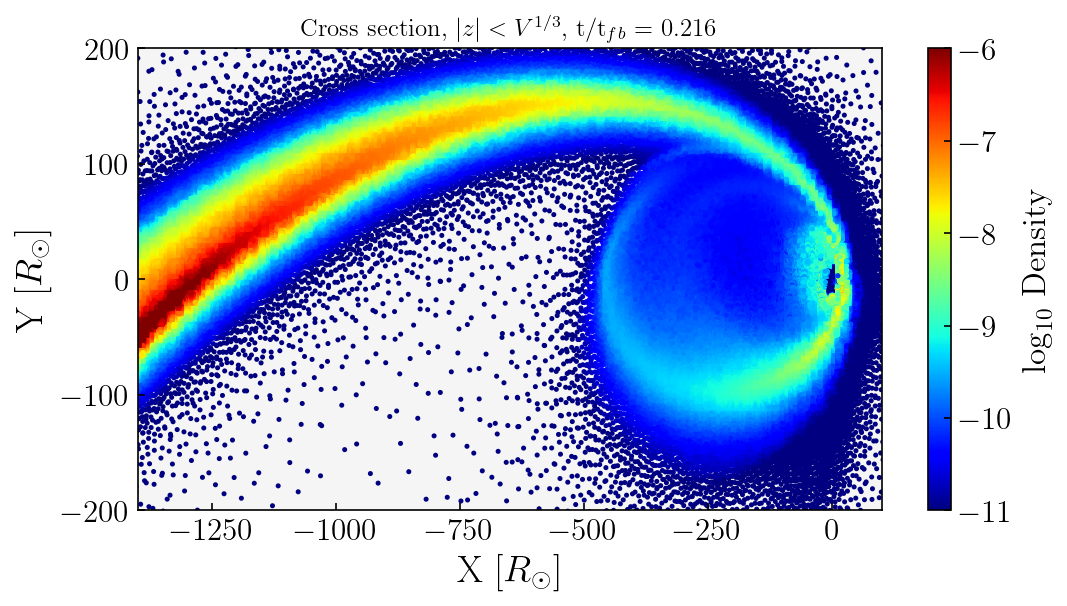

In [97]:
# Keplerian orbit
fig, ax = plt.subplots(1,1, figsize = (8,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 2, cmap = 'jet', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-1400,100)
ax.set_ylim(-200,200)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))


In [98]:
theta_lim = 3/4*np.pi
theta_arr = np.concatenate((np.arange(theta_lim, 0, -0.1), np.arange(0, -theta_lim, -0.1))) #0.01 as the epsilon in the find_sz plane function

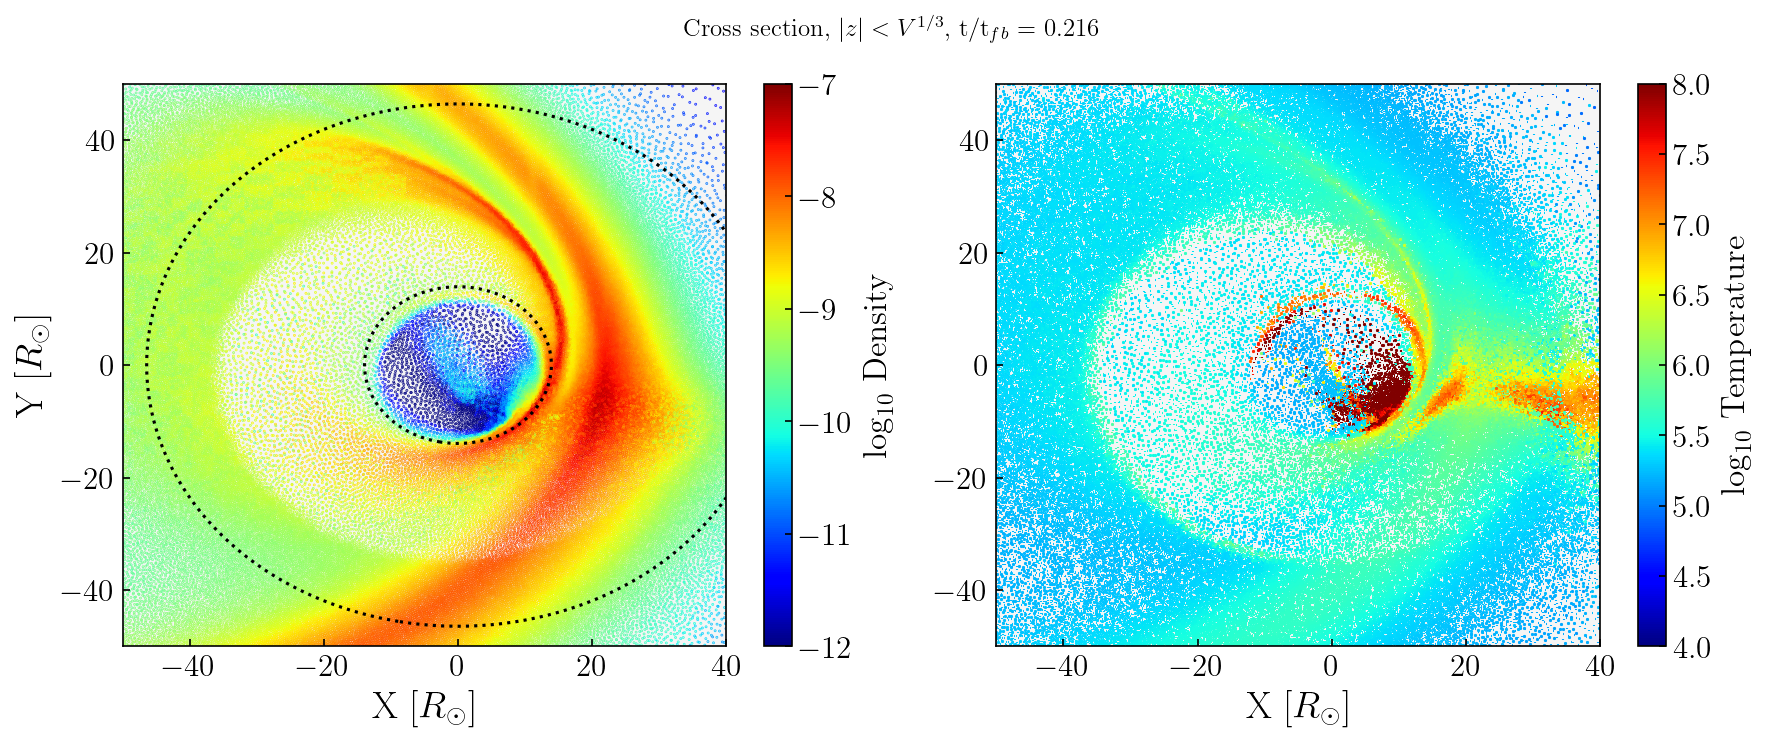

In [99]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
img = ax[0].scatter(X_cross, Y_cross, c = np.log10(Den_cross), s = 0.1, cmap = 'jet', vmin = -12, vmax = -7)
ax[0].contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax[0].contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[0].set_xlim(-50,40)
ax[0].set_ylim(-50,50)
ax[0].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[0].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

img1 = ax[1].scatter(X_cross, Y_cross, c = np.log10(Temp_cross), marker= 's', s = 0.1, cmap = 'jet', vmin = 4, vmax = 8)
cbar1 = plt.colorbar(img1)#, format='%.0e')
cbar1.set_label(r'$\log_{10}$ Temperature', fontsize = 16)
ax[1].set_xlim(-50,40)
ax[1].set_ylim(-50, 50)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.suptitle(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

plt.tight_layout()

/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_14135/3543780362.py:2: RuntimeWarning: invalid value encountered in log10
  img = ax.scatter(X_cross, Y_cross, c = np.log10(orb_en_cross), s = 0.1, cmap = 'jet', vmin = 1.2, vmax = 4.2)


Text(0.5, 1.0, 'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = 0.216')

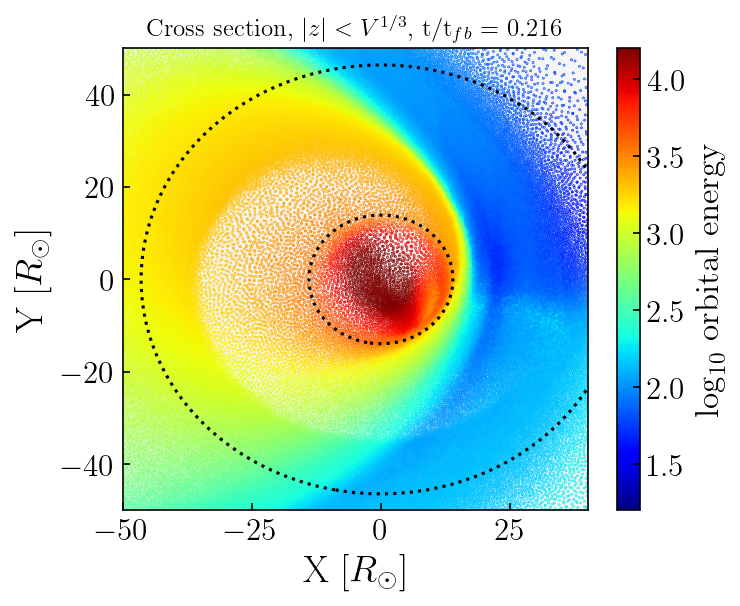

In [100]:
fig, ax = plt.subplots(figsize = (5,4))
img = ax.scatter(X_cross, Y_cross, c = np.log10(orb_en_cross), s = 0.1, cmap = 'jet', vmin = 1.2, vmax = 4.2)
ax.contour(xcfr, ycfr, cfr, [0], linestyles = 'dotted', colors = 'k')
ax.contour(xcfr0, ycfr0, cfr0, [0], linestyles = 'dotted', colors = 'k')
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label(r'$\log_{10}$ orbital energy', fontsize = 16)
ax.set_xlim(-50,40)
ax.set_ylim(-50,50)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))

X-Z plane

In [101]:
ychosen = Rp
crossXZ = np.abs(Y-ychosen) < dim_cell

X_crossXZ = X[crossXZ]
Z_crossXZ = Z[crossXZ]
VX_crossXZ = VX[crossXZ]
VZ_crossXZ = VZ[crossXZ]
Temp_crossXZ = Temp[crossXZ]
Den_crossXZ = Den[crossXZ]

Text(0.5, 1.0, 'Cross section, Y = $R_{p}$')

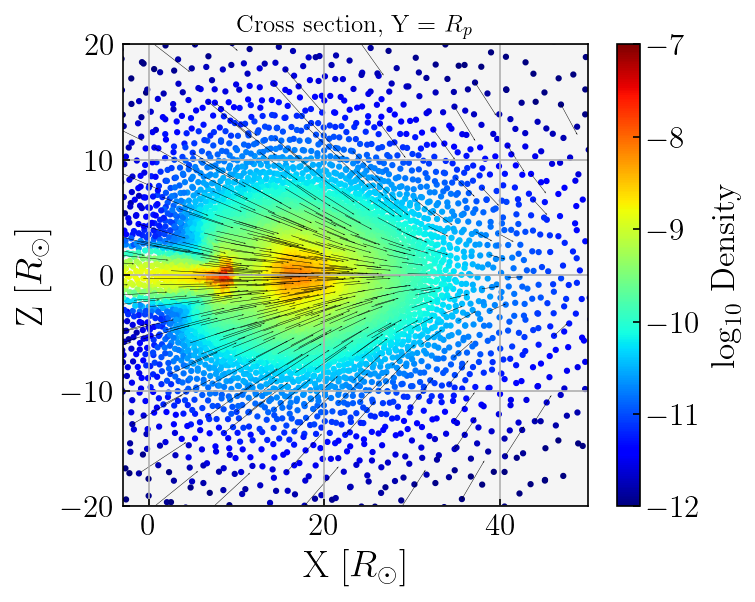

In [102]:
fig, ax = plt.subplots(1,1, figsize = (5,4))
img = ax.scatter(X_crossXZ, Z_crossXZ, c = np.log10(Den_crossXZ),  s = 4, cmap = 'jet', vmin = -12, vmax = -7)
ax.quiver(X_crossXZ[::20], Z_crossXZ[::20], VX_crossXZ[::20], VZ_crossXZ[::20], color = 'k', angles='xy', scale_units='xy', width = 1e-3, scale = 10)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax.set_xlim(-3,50)
ax.set_ylim(-20,20)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Z [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, Y = $R_{p}$')

NameError: name 'Diss_cross' is not defined

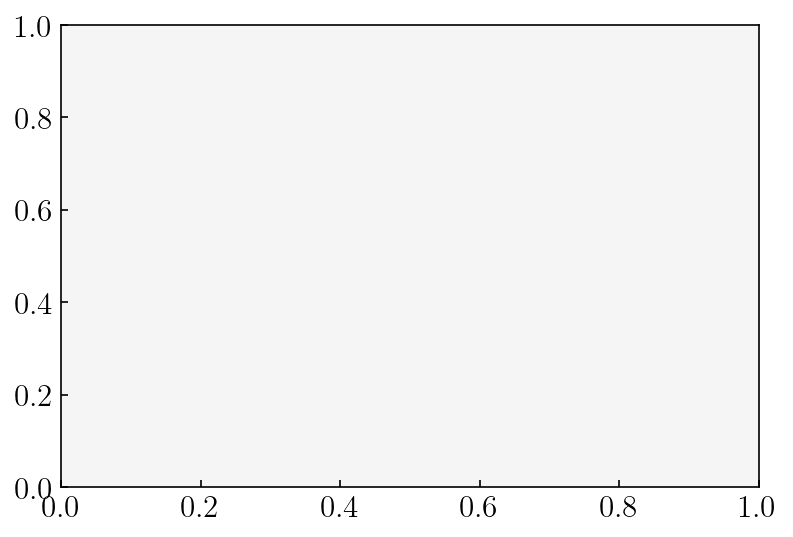

In [103]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
img = ax.scatter(X_cross, Y_cross, c = Diss_cross/Vol_cross, s = 5, cmap = 'jet', vmin = -1e-6, vmax = 1e-6)
cbar = plt.colorbar(img)#, format='%.0e')
cbar.set_label('energy density dissipation', fontsize = 16)
ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock zone')
#ax.plot(x_cross_surf, y_cross_surf, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='k', label = 'shock surface')
ax.set_xlim(3,29)
ax.set_ylim(-18,23)
ax.set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax.set_ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()
plt.title(r'Cross section, $|z|<V^{1/3}$, t/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.legend(loc = 'upper right')
#plt.savefig('Figs/EnDisszone.png')